<h3> Importing packages and raw data </h3>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("DS_assessment.csv")

<h3> Analysis of the Data </h3>

In [2]:
df.head()

,ID,Age,Experience,Income,Postal Code,Family Size,CCAvgSpending,Education,Mortgage,Investment Account,Deposit Account,InternetBanking,Personal Loan
0,1,25,1,49.0,91107,4.0,1.6,Undergrad,0,1,0,NO,NO
1,2,45,19,34.0,90089,3.0,1.5,Undergrad,0,1,0,NO,NO
2,3,39,15,11.0,94720,1.0,1.0,Undergrad,0,0,0,NO,NO
3,4,35,9,NaN,94112,1.0,2.7,Graduate,0,0,0,NO,NO
4,5,35,8,45.0,91330,4.0,1.0,Graduate,0,0,0,NO,NO


NO     0.904
YES    0.096
Name: Personal Loan, dtype: float64


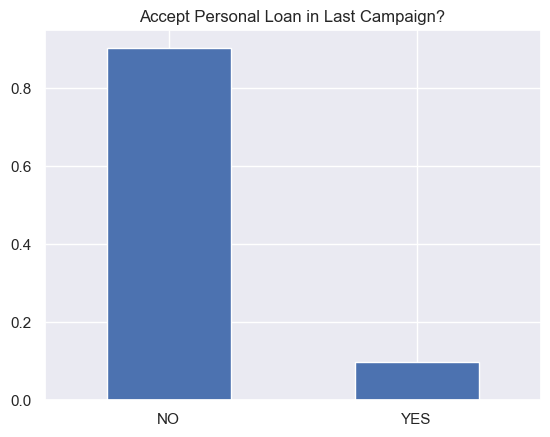

In [3]:
results = df['Personal Loan'].value_counts() / len(df['Personal Loan'])          #Highly Imbalanced dataset.

results.plot.bar(rot=0, title="Accept Personal Loan in Last Campaign?");
print(results)
#imbalanced dataset

<h3> Data Processing </h3>

In [4]:
#remove Age due to correlation with Experience
#remove Experience due to WoE Trend
#remove Mortgage due to high p-value and concentrated value of 0 (about 70% concentration)
#remove InternetBanking due to Very Weak Information Value and very low gap with WoE trend. 

#Coarse Classing: Education
#Coarse Classing: Family Size
#Coarse Classing: Income
#Coarse Classing: CCAvgSpending

In [5]:
df['Personal Loan'] = df['Personal Loan'].replace({'NO': 0, 'YES': 1})

In [6]:
df['Investment Account'] = df['Investment Account'].replace({'NO': 0, 'YES': 1})
df['Deposit Account'] = df['Deposit Account'].replace({'NO': 0, 'YES': 1})
df['InternetBanking'] = df['InternetBanking'].replace({'NO': 0, 'YES': 1})

In [7]:
# #Ordinal Encoding for Education - since it is known that Graduate is higher than undergrad, and advanced degree is higher than Graduate

df['Education'] = df['Education'].replace({'Undergrad': 0, 'Graduate': 1, 'Advanced Degree': 2})

In [8]:
df = df.dropna()       #missing counts represent < 5% of total population, can drop. 

0    0.903641
1    0.096359
Name: Personal Loan, dtype: float64


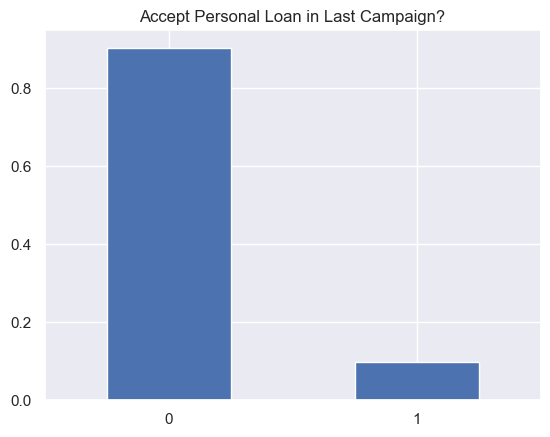

In [9]:
results = df['Personal Loan'].value_counts() / len(df['Personal Loan'])          #Highly Imbalanced dataset.

results.plot.bar(rot=0, title="Accept Personal Loan in Last Campaign?");
print(results)
#imbalanced dataset

<p> Age and experience are highly correlated, so will drop 1 of the variable randomly (Age) </p>

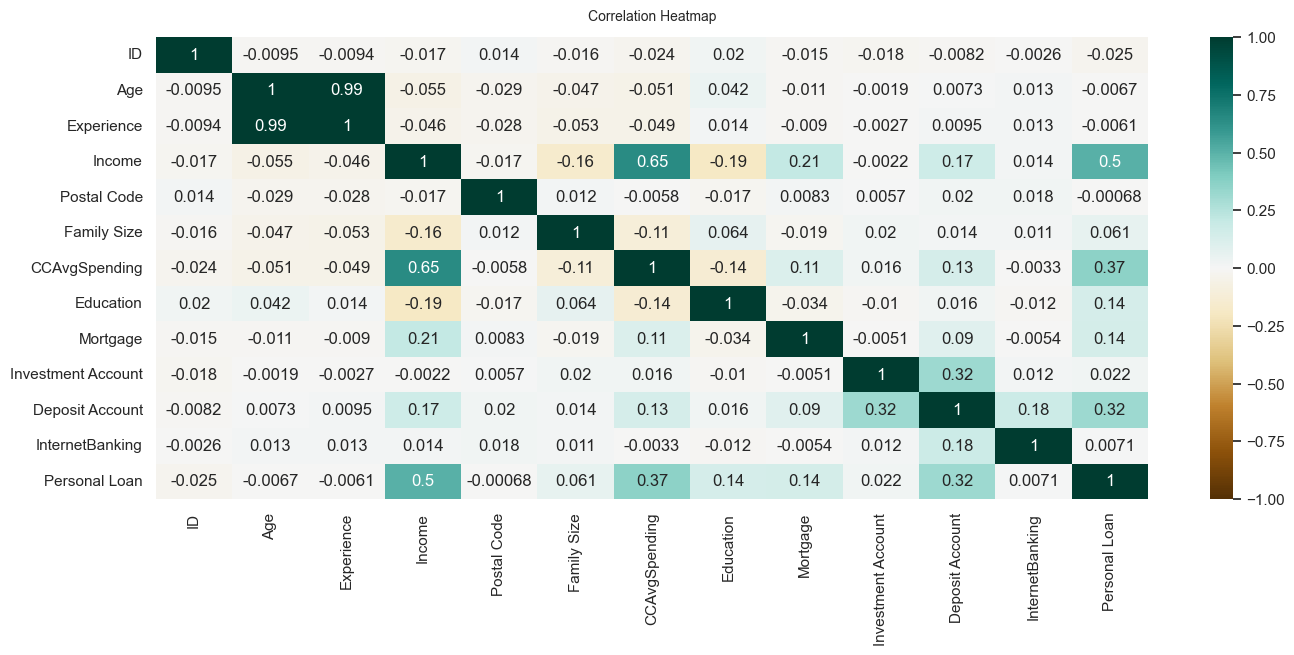

In [10]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10}, pad=12);

<h3> Single Factor Analysis (Fine-Classing)</h3>

<h3> For Discrete Variables </h3>

In [11]:
#good means that they converted. 
#bad means no conversion from liability customers to loan customers. 

def woe_discrete(categorical_var):
    
    WoE_results = pd.DataFrame()

    WoE_results[categorical_var] = df[categorical_var]
    WoE_results['Accept Loan Application offered'] = df['Personal Loan']

    Count = WoE_results.groupby([categorical_var]).count().reset_index()
    Mean = WoE_results.groupby([categorical_var]).mean().reset_index()

    df1 = pd.concat([Count, Mean], axis = 1)
    df1 = df1.iloc[:,[0,1,3]]

    df1.columns = [categorical_var, 'n_obs', 'prop_good']

    df1['prob_bad'] = 1 - df1['prop_good']

    df1['n_good'] = df1['prop_good'] * df1['n_obs']    
    df1['n_bad'] = df1['prob_bad'] * df1['n_obs']
    
    df1['prop_n_good'] = df1['n_good'] / df1['n_good'].sum()
    df1['prop_n_bad'] = df1['n_bad'] / df1['n_bad'].sum()

    df1['WoE'] = np.log(df1['prop_n_good'] / df1['prop_n_bad'])

    df1['%Good - %Bad'] = df1['prop_n_good'] - df1['prop_n_bad'] 

    df1['IV'] = df1['WoE'] * df1['%Good - %Bad']

    df1.IV = df1.IV.sum()
    
    df1.sort_values(by='WoE', inplace = True)

    return df1

In [12]:
def plot_by_woe(df, rotation_of_x_axis_labels = 0):
    x = np.array(df.iloc[:, 0].apply(str))               #matplotlib works better with numpy and scipy
    y = df['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

,Education,n_obs,prop_good,prob_bad,n_good,n_bad,prop_n_good,prop_n_bad,WoE,%Good - %Bad,IV
0,0,2083,0.044647,0.955353,93.0,1990.0,0.194154,0.443010,-0.824938,-0.248855,0.297687
1,1,1395,0.130466,0.869534,182.0,1213.0,0.379958,0.270036,0.341507,0.109923,0.297687
2,2,1493,0.136638,0.863362,204.0,1289.0,0.425887,0.286955,0.394851,0.138933,0.297687


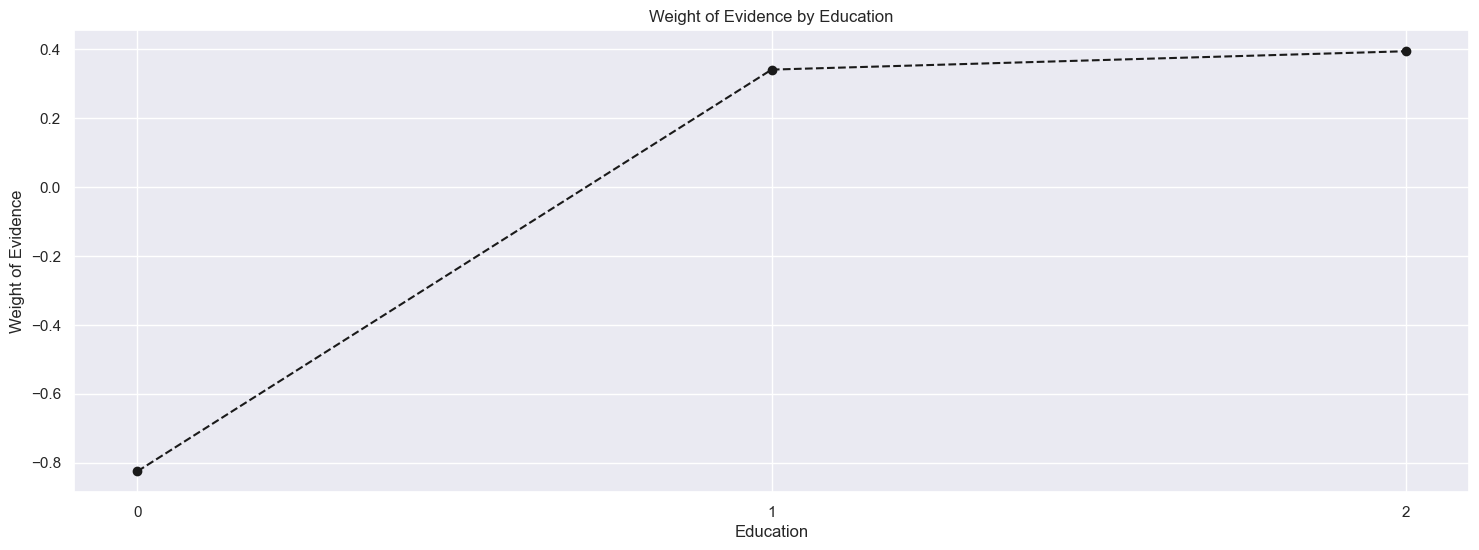

In [13]:
display(woe_discrete('Education'))                 #Show a good trend and IV. Coarse-class 1 and 2 together.
plot_by_woe(woe_discrete('Education'))   

,Family Size,n_obs,prop_good,prob_bad,n_good,n_bad,prop_n_good,prop_n_bad,WoE,%Good - %Bad,IV
0,1.0,1465,0.073038,0.926962,107.0,1358.0,0.223382,0.302315,-0.302587,-0.078933,0.066673
1,2.0,1290,0.082171,0.917829,106.0,1184.0,0.221294,0.263580,-0.174862,-0.042285,0.066673
3,4.0,1211,0.109827,0.890173,133.0,1078.0,0.277662,0.239982,0.145839,0.037680,0.066673
2,3.0,1005,0.132338,0.867662,133.0,872.0,0.277662,0.194123,0.357912,0.083539,0.066673


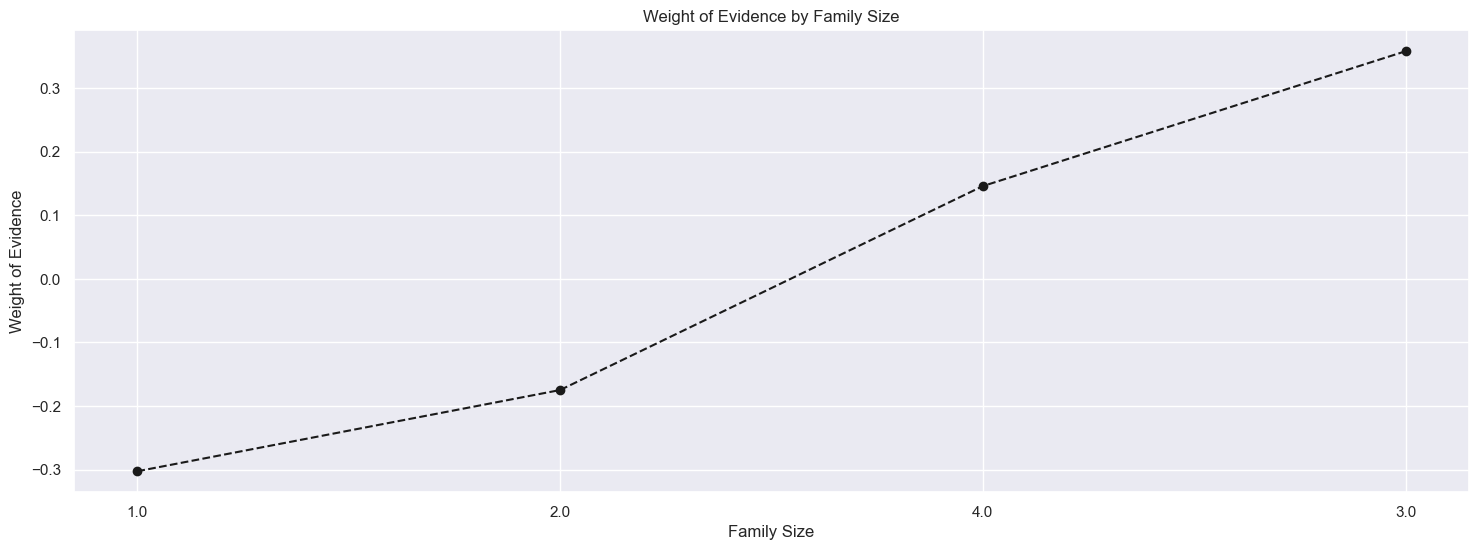

In [14]:
display(woe_discrete('Family Size'))                #Show a good trend. Since 3 and 4 are reversed, coarse class them. 3 means 3+ family size
plot_by_woe(woe_discrete('Family Size'))

,Investment Account,n_obs,prop_good,prob_bad,n_good,n_bad,prop_n_good,prop_n_bad,WoE,%Good - %Bad,IV
0,0,4451,0.094136,0.905864,419.0,4032.0,0.874739,0.897596,-0.025794,-0.022857,0.005195
1,1,520,0.115385,0.884615,60.0,460.0,0.125261,0.102404,0.201471,0.022857,0.005195


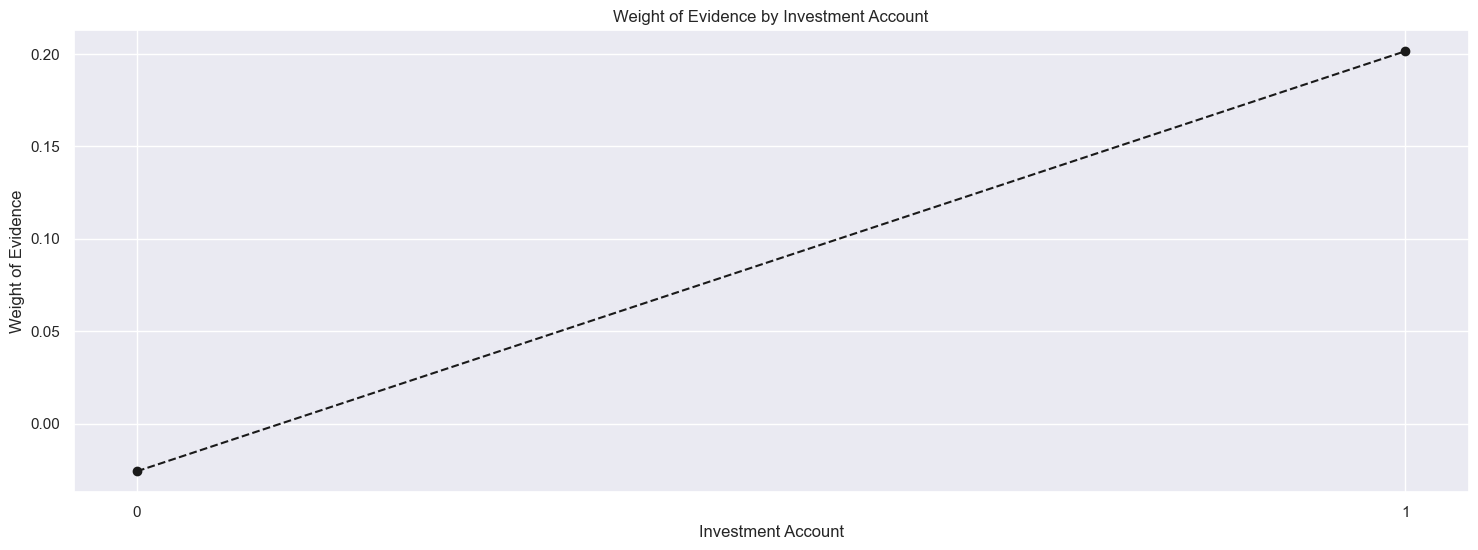

In [15]:
display(woe_discrete('Investment Account'))             #Keep, although quite weak trend

plot_by_woe(woe_discrete('Investment Account'))

,Deposit Account,n_obs,prop_good,prob_bad,n_good,n_bad,prop_n_good,prop_n_bad,WoE,%Good - %Bad,IV
0,0,4671,0.072575,0.927425,339.0,4332.0,0.707724,0.964381,-0.309432,-0.256657,0.619634
1,1,300,0.466667,0.533333,140.0,160.0,0.292276,0.035619,2.104821,0.256657,0.619634


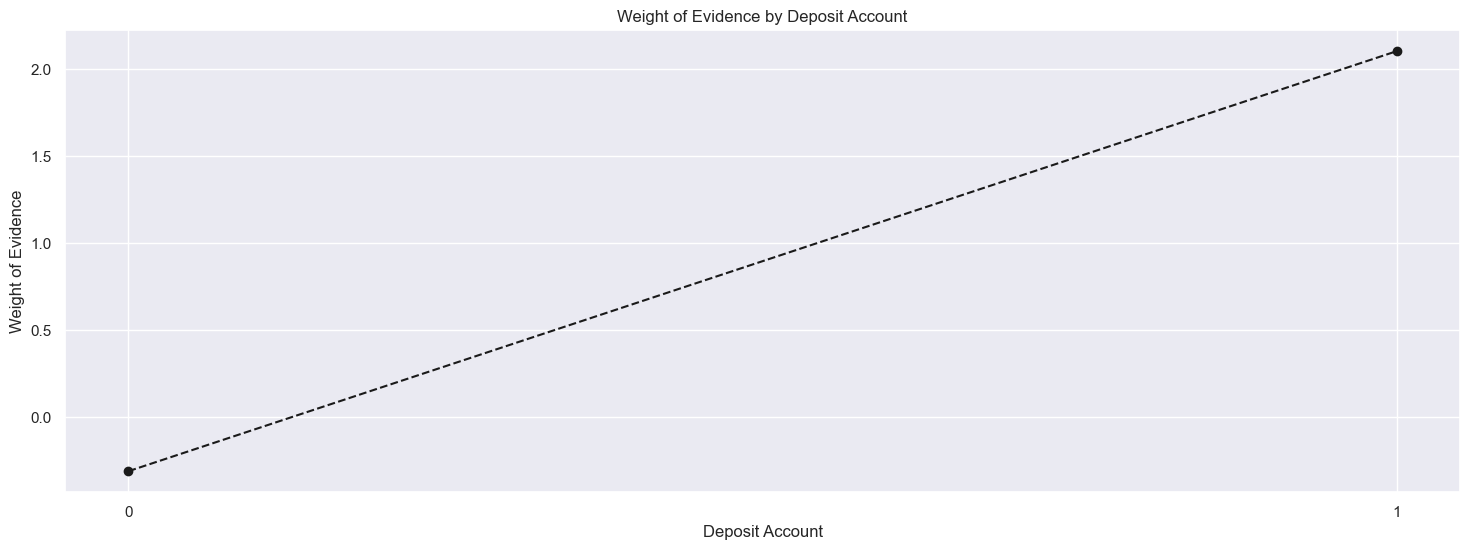

In [16]:
display(woe_discrete('Deposit Account'))                #Very good information value. Keep.

plot_by_woe(woe_discrete('Deposit Account'))

,InternetBanking,n_obs,prop_good,prob_bad,n_good,n_bad,prop_n_good,prop_n_bad,WoE,%Good - %Bad,IV
0,0,2004,0.093812,0.906188,188.0,1816.0,0.392484,0.404274,-0.029597,-0.01179,0.00058
1,1,2967,0.098079,0.901921,291.0,2676.0,0.607516,0.595726,0.019598,0.01179,0.00058


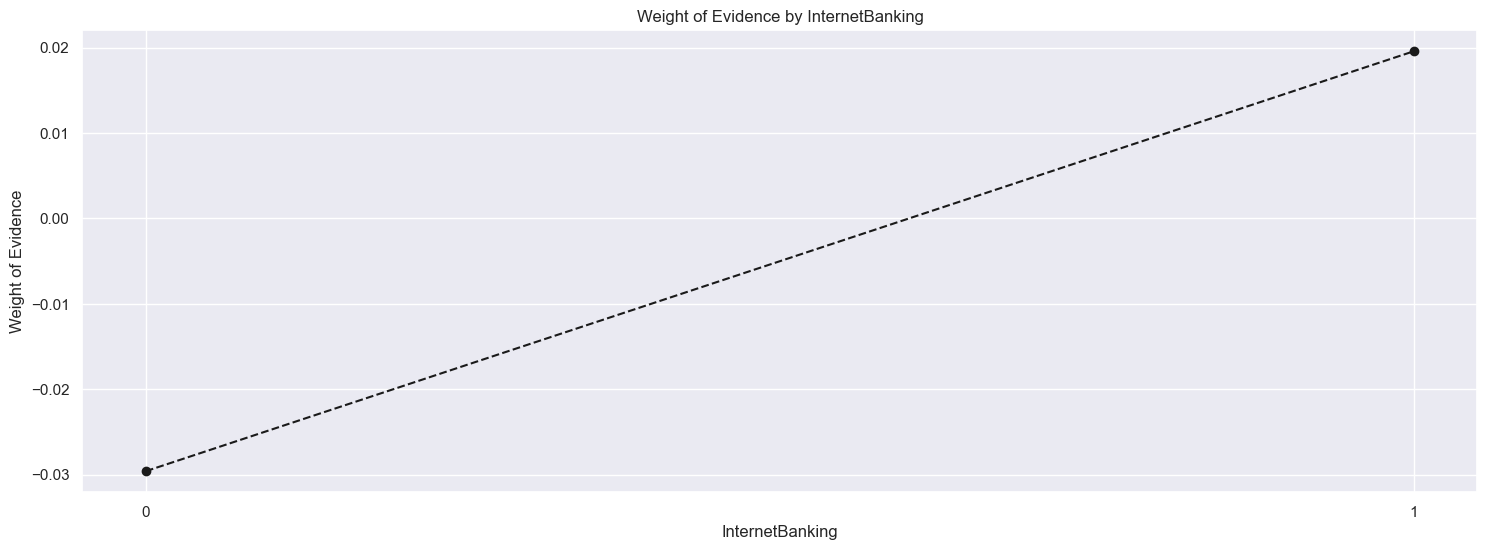

In [17]:
display(woe_discrete('InternetBanking'))             #Very Weak Information Value, drop this variable. 

plot_by_woe(woe_discrete('InternetBanking'))

<h3> For Continuous Variable </h3>

In [18]:
def woe_continuous(continuous_var):
    
    WoE_results = pd.DataFrame()

    WoE_results[continuous_var] = df[continuous_var]
    WoE_results['Accept Loan Application offered'] = df['Personal Loan']

    Count = WoE_results.groupby([continuous_var]).count().reset_index()
    Mean = WoE_results.groupby([continuous_var]).mean().reset_index()

    df1 = pd.concat([Count, Mean], axis = 1)
    df1 = df1.iloc[:,[0,1,3]]

    df1.columns = [continuous_var, 'n_obs', 'prop_good']

    df1['prob_bad'] = 1 - df1['prop_good']
    
    df1['n_good'] = df1['prop_good'] * df1['n_obs']
    df1['n_bad'] = df1['prob_bad'] * df1['n_obs']

    df1['prop_n_good'] = df1['n_good'] / df1['n_good'].sum()
    df1['prop_n_bad'] = df1['n_bad'] / df1['n_bad'].sum()

    df1['WoE'] = np.log(df1['prop_n_good'] / df1['prop_n_bad'])

    df1['%Good - %Bad'] = df1['prop_n_good'] - df1['prop_n_bad'] 

    df1['IV'] = df1['WoE'] * df1['%Good - %Bad']

    df1.IV = np.sum(df1.IV)

    return df1

,Experience_Bins,n_obs,prop_good,prob_bad,n_good,n_bad,prop_n_good,prop_n_bad,WoE,%Good - %Bad,IV
0,"(-3.001, 4.0]",516,0.094961,0.905039,49.0,467.0,0.102296,0.103963,-0.016156,-0.001666,0.021115
1,"(4.0, 8.0]",503,0.111332,0.888668,56.0,447.0,0.116910,0.099510,0.161146,0.017400,0.021115
2,"(8.0, 12.0]",478,0.117155,0.882845,56.0,422.0,0.116910,0.093945,0.218699,0.022965,0.021115
3,"(12.0, 17.0]",614,0.074919,0.925081,46.0,568.0,0.096033,0.126447,-0.275127,-0.030414,0.021115
4,"(17.0, 20.0]",417,0.103118,0.896882,43.0,374.0,0.089770,0.083259,0.075297,0.006511,0.021115
5,"(20.0, 24.0]",510,0.088235,0.911765,45.0,465.0,0.093946,0.103517,-0.097022,-0.009572,0.021115
6,"(24.0, 28.0]",534,0.091760,0.908240,49.0,485.0,0.102296,0.107970,-0.053976,-0.005673,0.021115
7,"(28.0, 32.0]",506,0.100791,0.899209,51.0,455.0,0.106472,0.101291,0.049881,0.005181,0.021115
8,"(32.0, 36.0]",497,0.084507,0.915493,42.0,455.0,0.087683,0.101291,-0.144275,-0.013609,0.021115
9,"(36.0, 43.0]",396,0.106061,0.893939,42.0,354.0,0.087683,0.078807,0.106725,0.008876,0.021115


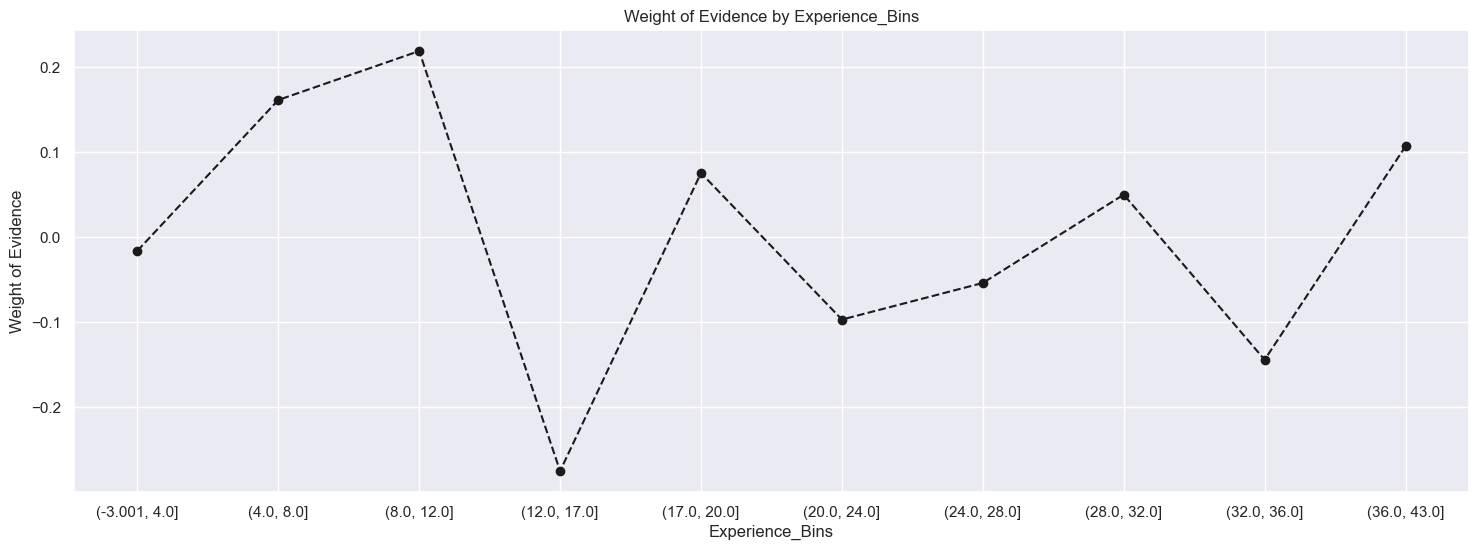

In [19]:
df['Experience_Bins'] = pd.qcut(df['Experience'], 10)

display(woe_continuous('Experience_Bins'))           # no observable pattern, and since low IV, drop. 

plot_by_woe(woe_continuous('Experience_Bins'))

C:\Users\ngchi\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Income_Bins,n_obs,prop_good,prob_bad,n_good,n_bad,prop_n_good,prop_n_bad,WoE,%Good - %Bad,IV
0,"(7.999, 22.0]",506,0.000000,1.000000,0.0,506.0,0.000000,0.112645,-inf,-0.112645,inf
1,"(22.0, 33.0]",519,0.000000,1.000000,0.0,519.0,0.000000,0.115539,-inf,-0.115539,inf
2,"(33.0, 42.0]",516,0.000000,1.000000,0.0,516.0,0.000000,0.114871,-inf,-0.114871,inf
3,"(42.0, 52.0]",451,0.000000,1.000000,0.0,451.0,0.000000,0.100401,-inf,-0.100401,inf
4,"(52.0, 64.0]",541,0.003697,0.996303,2.0,539.0,0.004175,0.119991,-3.358216,-0.115816,inf
5,"(64.0, 78.0]",466,0.010730,0.989270,5.0,461.0,0.010438,0.102627,-2.285607,-0.092188,inf
6,"(78.0, 89.0]",511,0.027397,0.972603,14.0,497.0,0.029228,0.110641,-1.331180,-0.081414,inf
7,"(89.0, 113.0]",486,0.129630,0.870370,63.0,423.0,0.131524,0.094167,0.334115,0.037357,inf
8,"(113.0, 145.0]",493,0.338742,0.661258,167.0,326.0,0.348643,0.072573,1.569449,0.276070,inf
9,"(145.0, 224.0]",482,0.473029,0.526971,228.0,254.0,0.475992,0.056545,2.130364,0.419447,inf


C:\Users\ngchi\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


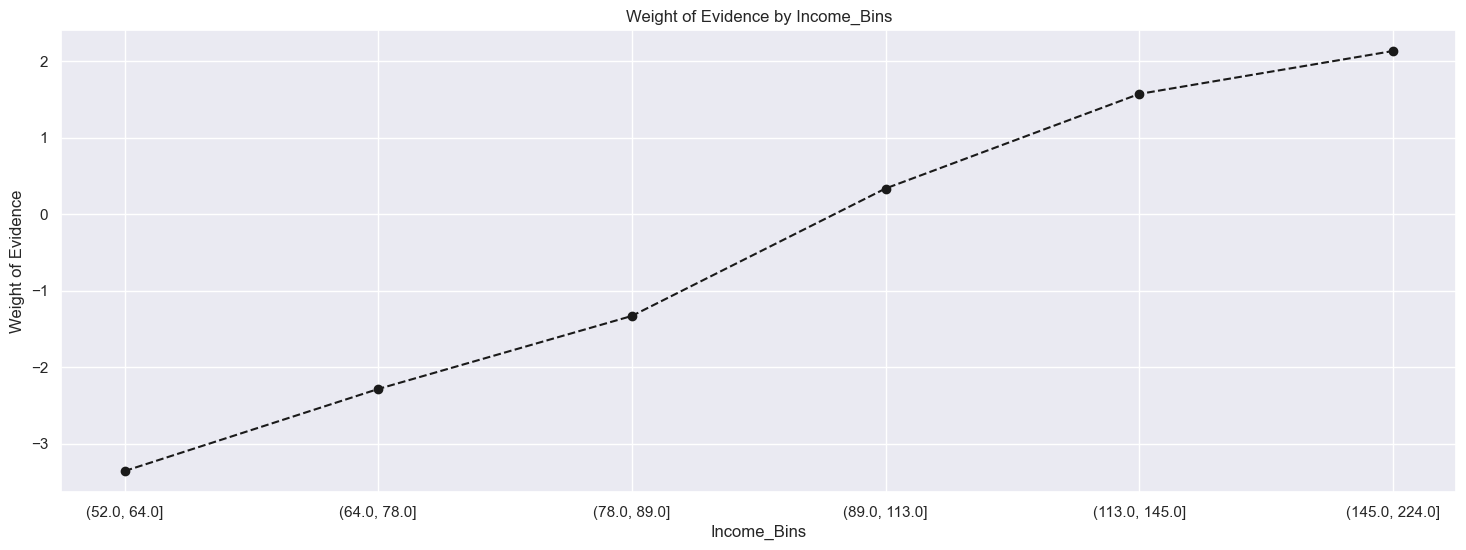

In [20]:
df['Income_Bins'] = pd.qcut(df['Income'], 10)

display(woe_continuous('Income_Bins'))           # very clear pattern from (52.0, 64.0] onwards. To Keep. 

plot_by_woe(woe_continuous('Income_Bins'))

,CCAvgSpending_Bins,n_obs,prop_good,prob_bad,n_good,n_bad,prop_n_good,prop_n_bad,WoE,%Good - %Bad,IV
0,"(-0.001, 0.3]",728,0.023352,0.976648,17.0,711.0,0.035491,0.158281,-1.495106,-0.122791,1.627685
1,"(0.3, 0.5]",340,0.035294,0.964706,12.0,328.0,0.025052,0.073019,-1.069754,-0.047967,1.627685
2,"(0.5, 0.8]",501,0.029940,0.970060,15.0,486.0,0.031315,0.108192,-1.239806,-0.076877,1.627685
3,"(0.8, 1.1]",420,0.028571,0.971429,12.0,408.0,0.025052,0.090828,-1.288008,-0.065776,1.627685
4,"(1.1, 1.5]",514,0.042802,0.957198,22.0,492.0,0.045929,0.109528,-0.869084,-0.063599,1.627685
5,"(1.5, 1.9]",536,0.026119,0.973881,14.0,522.0,0.029228,0.116207,-1.380258,-0.086979,1.627685
6,"(1.9, 2.3]",475,0.040000,0.960000,19.0,456.0,0.039666,0.101514,-0.939701,-0.061848,1.627685
7,"(2.3, 2.8]",504,0.055556,0.944444,28.0,476.0,0.058455,0.105966,-0.594861,-0.047511,1.627685
8,"(2.8, 4.3]",467,0.329764,0.670236,154.0,313.0,0.321503,0.069679,1.529102,0.251824,1.627685
9,"(4.3, 10.0]",486,0.382716,0.617284,186.0,300.0,0.388309,0.066785,1.760317,0.321524,1.627685


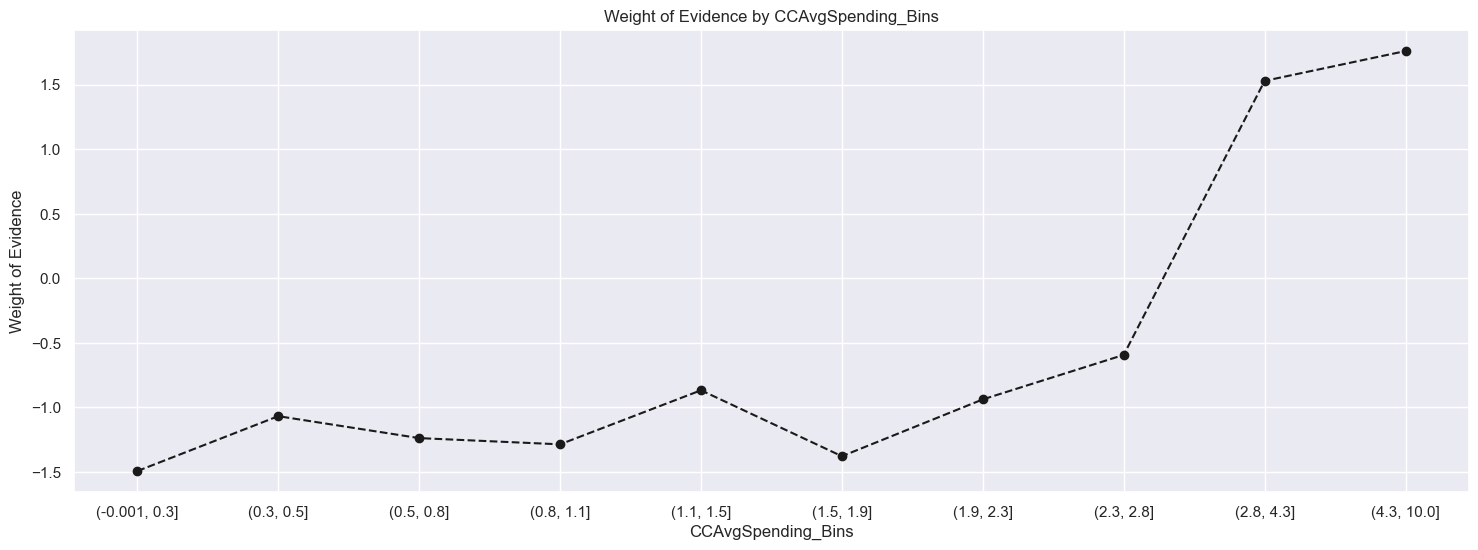

In [21]:
df['CCAvgSpending_Bins'] = pd.qcut(df['CCAvgSpending'], 10)        # Maybe group the bins from (-0.001 TO 1.1], (1.1 TO 2.3]. 

display(woe_continuous('CCAvgSpending_Bins'))           

plot_by_woe(woe_continuous('CCAvgSpending_Bins'))

<h3> Coarse Classing </h3>

<p> Education </p>

,Education_Coarse_Class,n_obs,prop_good,prob_bad,n_good,n_bad,prop_n_good,prop_n_bad,WoE,%Good - %Bad,IV
0,0,2083,0.044647,0.955353,93.0,1990.0,0.194154,0.44301,-0.824938,-0.248855,0.297203
1,1,2888,0.133657,0.866343,386.0,2502.0,0.805846,0.55699,0.369344,0.248855,0.297203


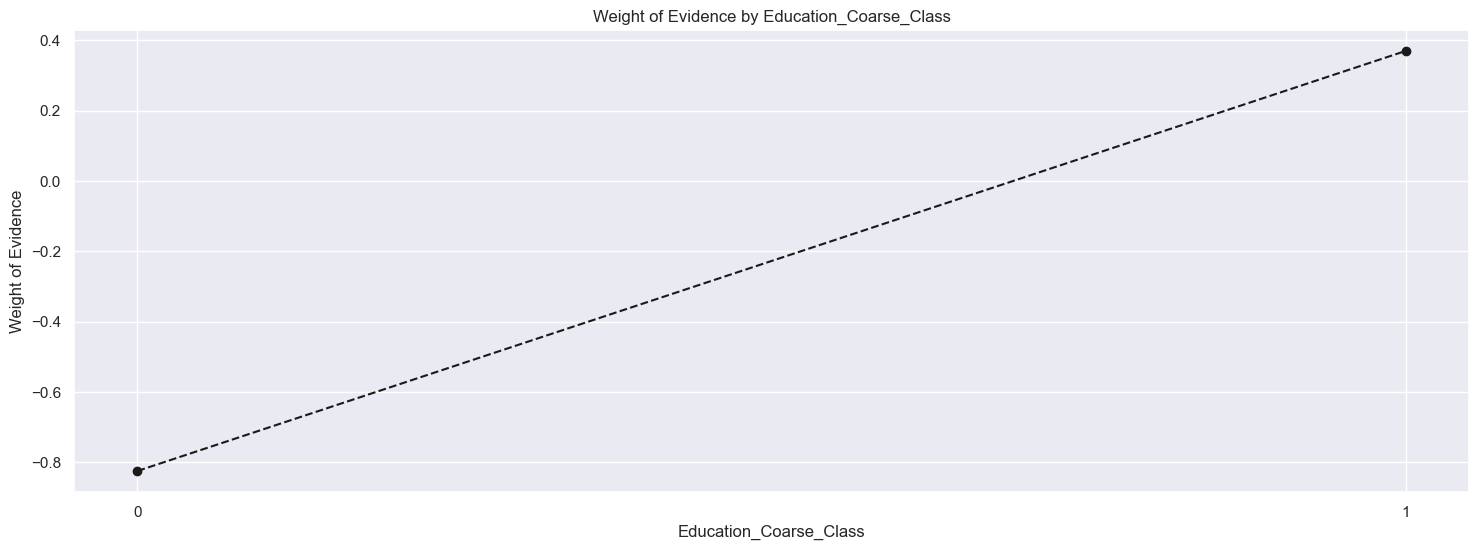

In [22]:
df['Education_Coarse_Class'] = df['Education'].replace({2: 1})      #improve model performance

display(woe_discrete('Education_Coarse_Class'))                 
plot_by_woe(woe_discrete('Education_Coarse_Class'))  

<p> Family Size </p>

,Family Size_Coarse_Class,n_obs,prop_good,prob_bad,n_good,n_bad,prop_n_good,prop_n_bad,WoE,%Good - %Bad,IV
0,1.0,1465,0.073038,0.926962,107.0,1358.0,0.223382,0.302315,-0.302587,-0.078933,0.06113
1,2.0,1290,0.082171,0.917829,106.0,1184.0,0.221294,0.263580,-0.174862,-0.042285,0.06113
2,3.0,2216,0.120036,0.879964,266.0,1950.0,0.555324,0.434105,0.246264,0.121219,0.06113


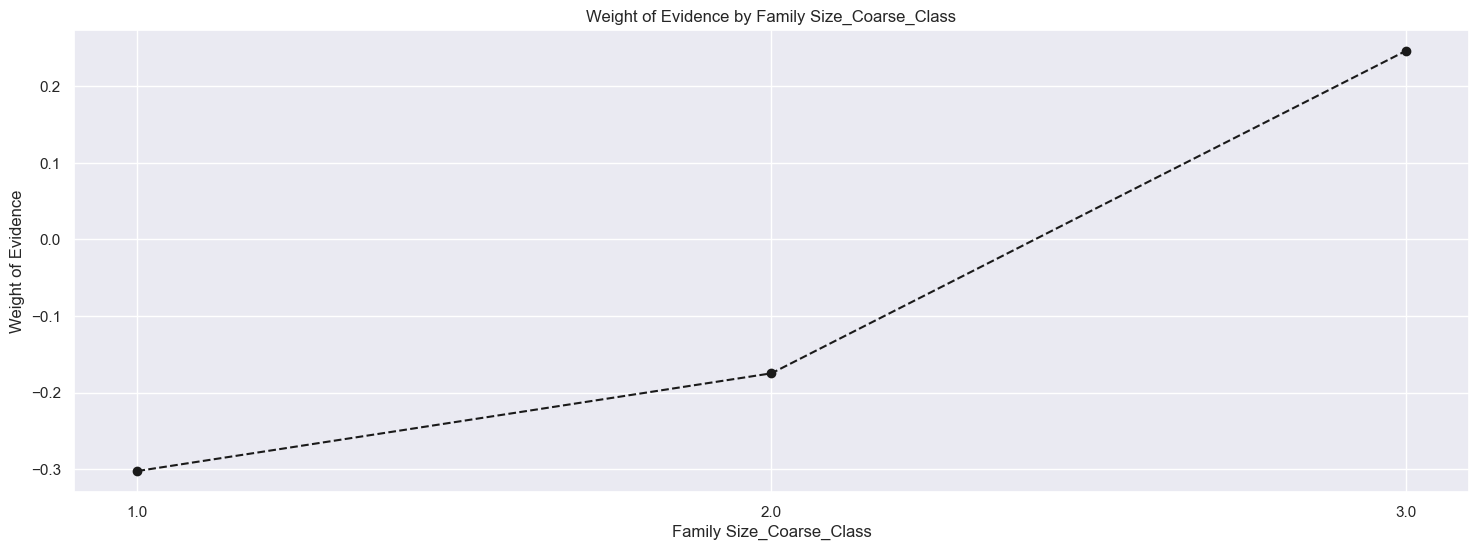

In [23]:
df['Family Size_Coarse_Class'] = df['Family Size'].replace({4: 3})     #improve model performance

display(woe_discrete('Family Size_Coarse_Class'))                
plot_by_woe(woe_discrete('Family Size_Coarse_Class'))

<p> Income </p>

In [24]:
df = df.merge(woe_continuous('Income_Bins')[['Income_Bins', 'WoE']], how = 'inner', on = 'Income_Bins') #improve model performance
df.rename(columns = {'WoE': 'Income_WoE'}, inplace = True)
df['Income_WoE'] = df['Income_WoE'].replace({-np.inf: -3.358216})

C:\Users\ngchi\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<p> CCAvgSpending </p>

In [25]:
df = df.merge(woe_continuous('CCAvgSpending_Bins')[['CCAvgSpending_Bins', 'WoE']], how = 'inner', on = 'CCAvgSpending_Bins')
df.rename(columns = {'WoE': 'CCAvgSpending_Bins_WoE'}, inplace = True)

def apply(df):
    
    if df['CCAvgSpending'] <= 1.1:
        return -1.288008
    
    elif (1.1 > df['CCAvgSpending'] <= 2.3):
        return -0.939701
    
    else:
        return df['CCAvgSpending_Bins_WoE']

df['CCAvgSpending_Bins_WoE'] = df.apply(apply, axis = 1)

<h3> Train-Test Split </h3>

In [26]:
import numpy as np
from sklearn.model_selection import train_test_split

#remove Age due to correlation with Experience
#remove Experience due to WoE Trend
#remove Mortgage due to high p-value and concentrated value of 0 (about 70% concentration)
#remove InternetBanking due to Very Weak Information Value and very low gap with WoE trend. 

#Coarse Classing: Education
#Coarse Classing: Family Size
#Coarse Classing: Income
#Coarse Classing: CCAvgSpending

X = df[['Income_WoE', 'CCAvgSpending_Bins_WoE','Family Size_Coarse_Class', 'Education_Coarse_Class', 'Deposit Account', 'Investment Account']]
y = df['Personal Loan']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

<h3> Standardizing all the features </h3>

<p> Scale the features so that features with larger value such as income compared to age won't be given higher coefficients if they are not necessarily more important. <br><br>Algorithms like Logistic Regression which use the weighted-sum of input variables will be affected if the scale is not standardized.</p>

<p> When the features are standardized, the magnitude of the coefficients in logistic regression directly reflects the importance of each feature. </p>

In [27]:
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(X_train)
scaled_train_features_df = pd.DataFrame(scaled_train_features, index=X_train.index, columns=X_train.columns)
X_train = scaled_train_features_df

scaled_test_features = scaler.transform(X_test)
scaled_test_features_df = pd.DataFrame(scaled_test_features, index=X_test.index, columns=X_test.columns)
X_test = scaled_test_features_df

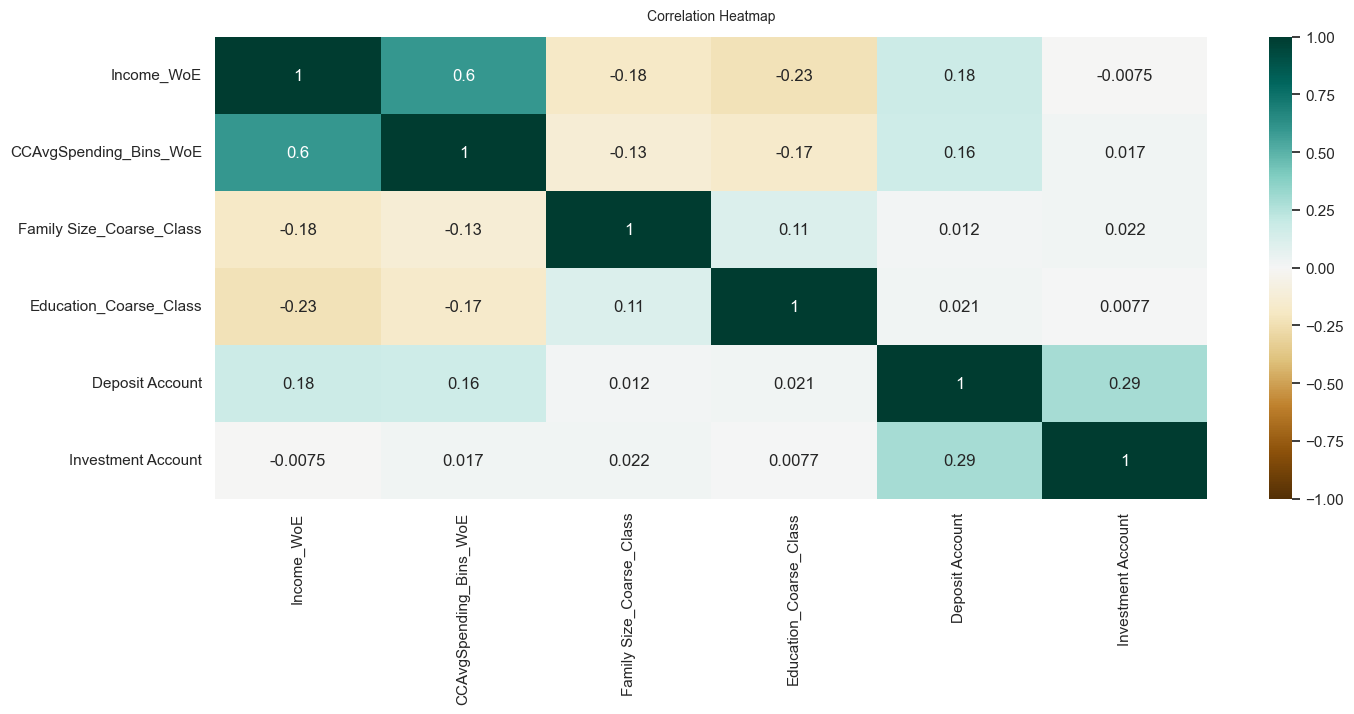

In [28]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10}, pad=12);

<h3> Training the Logistic Regression model </h3>

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm

X_train = sm.add_constant(X_train)

#fitting log reg model
model = sm.Logit(y_train, X_train)
trained_model = model.fit()

print(trained_model.summary())

Optimization terminated successfully.
         Current function value: 0.098655
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:          Personal Loan   No. Observations:                 3330
Model:                          Logit   Df Residuals:                     3323
Method:                           MLE   Df Model:                            6
Date:                Wed, 10 Jan 2024   Pseudo R-squ.:                  0.6940
Time:                        23:57:43   Log-Likelihood:                -328.52
converged:                       True   LL-Null:                       -1073.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -6.2153      0.339    -18.326      0.000      -6.88

In [30]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

coefficients = log_reg.coef_[0]

print(coefficients)

# feature_importance = pd.DataFrame({'Features': X_train.columns, 'Absolute Coefficient': np.abs(coefficients)})
# feature_importance = feature_importance.sort_values('Absolute Coefficient', ascending=True)
# feature_importance.plot(x='Features', y='Absolute Coefficient', kind='barh', figsize=(10, 6))

[ 1.28189204e-05  3.27668255e+00  7.27741686e-01  9.74601489e-01
  1.93409846e+00  6.94924139e-01 -1.16937799e-01]


<h3> Testing the Logistic Regression model </h3>

<p> Holdout Sample test </p> 

In [31]:
X_test = sm.add_constant(X_test)

probs = log_reg.predict_proba(X_test)
probs = probs[:, 1]
probs = pd.Series(probs).reset_index().drop('index', axis = 1)[0]

predict = log_reg.predict(X_test)
predict = pd.Series(predict).reset_index().drop('index', axis = 1)[0]

actual = y_test.reset_index().drop('index', axis = 1)['Personal Loan']

ar_compare_log = pd.DataFrame()
ar_compare_log['actual'] = actual
ar_compare_log['predict'] = predict
ar_compare_log['probabilities'] = probs

ar_compare_log

,actual,predict,probabilities
0,0,0,0.000674
1,0,0,0.000583
2,0,0,0.000037
3,1,0,0.488844
4,0,0,0.000141
...,...,...,...
1636,0,0,0.014220
1637,0,0,0.000760
1638,0,0,0.000419
1639,0,0,0.000008


In [32]:
TN = ar_compare_log[(ar_compare_log['actual'] == 0) & (ar_compare_log['predict'] == 0)]
TP = ar_compare_log[(ar_compare_log['actual'] == 1) & (ar_compare_log['predict'] == 1)]
FN = ar_compare_log[(ar_compare_log['actual'] == 0) & (ar_compare_log['predict'] == 1)]
FP = ar_compare_log[(ar_compare_log['actual'] == 1) & (ar_compare_log['predict'] == 0)]

Confusion_List = []
TP_FP = [len(TP),len(FP)]
FN_TN = [len(FN),len(TN)]
Confusion_List.append(TP_FP)
Confusion_List.append(FN_TN)

Confusion_Matrix = pd.DataFrame(Confusion_List)
Confusion_Matrix.rename(columns = {0: 'Actual: 1', 1: "Actual: 0"}, inplace = True)
Confusion_Matrix.rename(index = {0: 'Predicted: 1', 1: "Predicted: 0"}, inplace = True)

Confusion_Matrix

,Actual: 1,Actual: 0
Predicted: 1,120,30
Predicted: 0,13,1478


<h3> Logistic Regression model Results </h3>

In [33]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [34]:
fpr, tpr, thresholds = roc_curve(ar_compare_log['actual'], ar_compare_log['probabilities'])
roc_auc = auc(fpr, tpr)

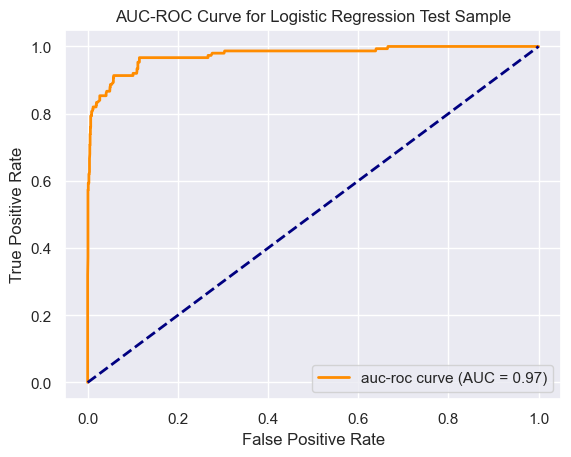

In [35]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='auc-roc curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve for Logistic Regression Test Sample')
plt.legend(loc='lower right')
plt.show()

In [36]:
ROC = roc_auc_score(ar_compare_log['actual'], ar_compare_log['probabilities'])
print('AUC-ROC: ' + str(ROC))

AUC-ROC: 0.9745517549742901


In [37]:
gini_coefficient = 2 * roc_auc - 1
gini_coefficient

0.9491035099485803

<h3> Decision Tree </h3>

In [38]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

classifier = tree.DecisionTreeClassifier()
#Since decision tree are great at capturing non-linear and complex relationships between features and the target variable, 
#there is no need to go through the WoE method of fine-classing and coarse classing
#Also don't need to standardize the units as well. 

X = df[['Income','Family Size', 'CCAvgSpending', 'Education', 'Deposit Account']]
y = df['Personal Loan']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

classifier = classifier.fit(X_train, y_train)

In [39]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = DecisionTreeClassifier()

param_grid = {
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)

classifier = DecisionTreeClassifier(**best_params)
classifier.fit(X_train, y_train)

Best Hyperparameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


DecisionTreeClassifier(max_depth=3)

<Axes: ylabel='features'>

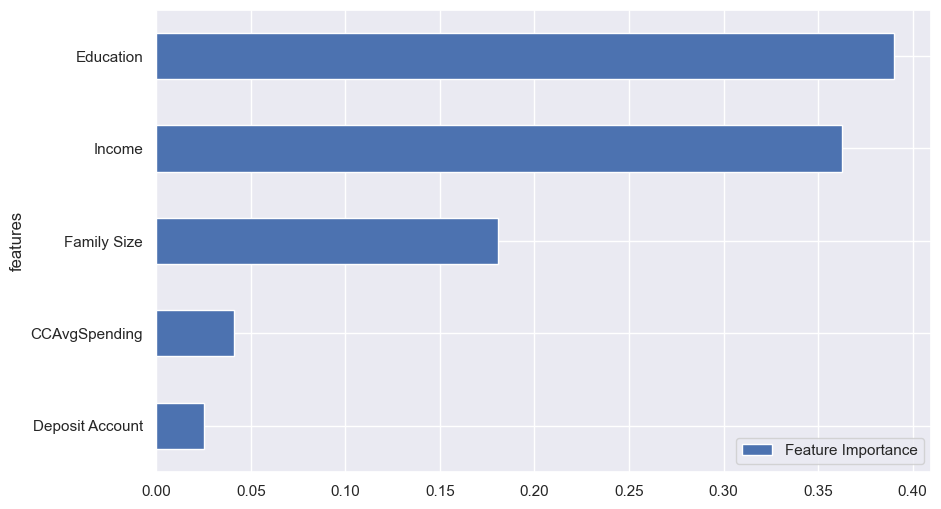

In [40]:
feature_names = X_train.columns

feature_importance = pd.DataFrame(classifier.feature_importances_, index = feature_names).sort_values(by = 0, ascending = True).reset_index()
feature_importance.rename(columns = {'index': 'features', 0 : 'Feature Importance'}, inplace = True)
feature_importance.plot(x='features', y='Feature Importance', kind='barh', figsize=(10, 6))

In [41]:
X_train.head()

,Income,Family Size,CCAvgSpending,Education,Deposit Account
368,105.0,4.0,1.7,1,0
4877,140.0,2.0,7.6,0,0
785,33.0,3.0,0.9,0,0
4929,115.0,3.0,4.6,2,0
3585,94.0,1.0,1.5,2,0


In [42]:
probs_tree = classifier.predict_proba(X_test)
probs_tree = probs_tree[:, 1]
probs_tree = pd.Series(probs_tree).reset_index().drop('index', axis = 1)[0]

predict_tree = classifier.predict(X_test)
predict_tree = pd.Series(predict_tree).reset_index().drop('index', axis = 1)[0]

actual = y_test.reset_index().drop('index', axis = 1)['Personal Loan']

ar_compare_tree = pd.DataFrame()
ar_compare_tree['actual'] = actual
ar_compare_tree['predict'] = predict_tree
ar_compare_tree['probabilities'] = probs_tree

ar_compare_tree

,actual,predict,probabilities
0,0,0,0.000000
1,0,0,0.000000
2,0,0,0.000000
3,1,1,0.964286
4,0,0,0.000000
...,...,...,...
1636,0,1,0.964286
1637,0,0,0.000000
1638,0,0,0.000000
1639,0,0,0.000000


In [43]:
TN_tree = ar_compare_tree[(ar_compare_tree['actual'] == 0) & (ar_compare_tree['predict'] == 0)]
TP_tree = ar_compare_tree[(ar_compare_tree['actual'] == 1) & (ar_compare_tree['predict'] == 1)]
FN_tree = ar_compare_tree[(ar_compare_tree['actual'] == 0) & (ar_compare_tree['predict'] == 1)]
FP_tree = ar_compare_tree[(ar_compare_tree['actual'] == 1) & (ar_compare_tree['predict'] == 0)]

Confusion_List = []
TP_FP = [len(TP_tree),len(FP_tree)]
FN_TN = [len(FN_tree),len(TN_tree)]
Confusion_List.append(TP_FP)
Confusion_List.append(FN_TN)

Confusion_Matrix = pd.DataFrame(Confusion_List)
Confusion_Matrix.rename(columns = {0: 'Actual: 1', 1: "Actual: 0"}, inplace = True)
Confusion_Matrix.rename(index = {0: 'Predicted: 1', 1: "Predicted: 0"}, inplace = True)

Confusion_Matrix

,Actual: 1,Actual: 0
Predicted: 1,129,21
Predicted: 0,9,1482


<h3> Results </h3>

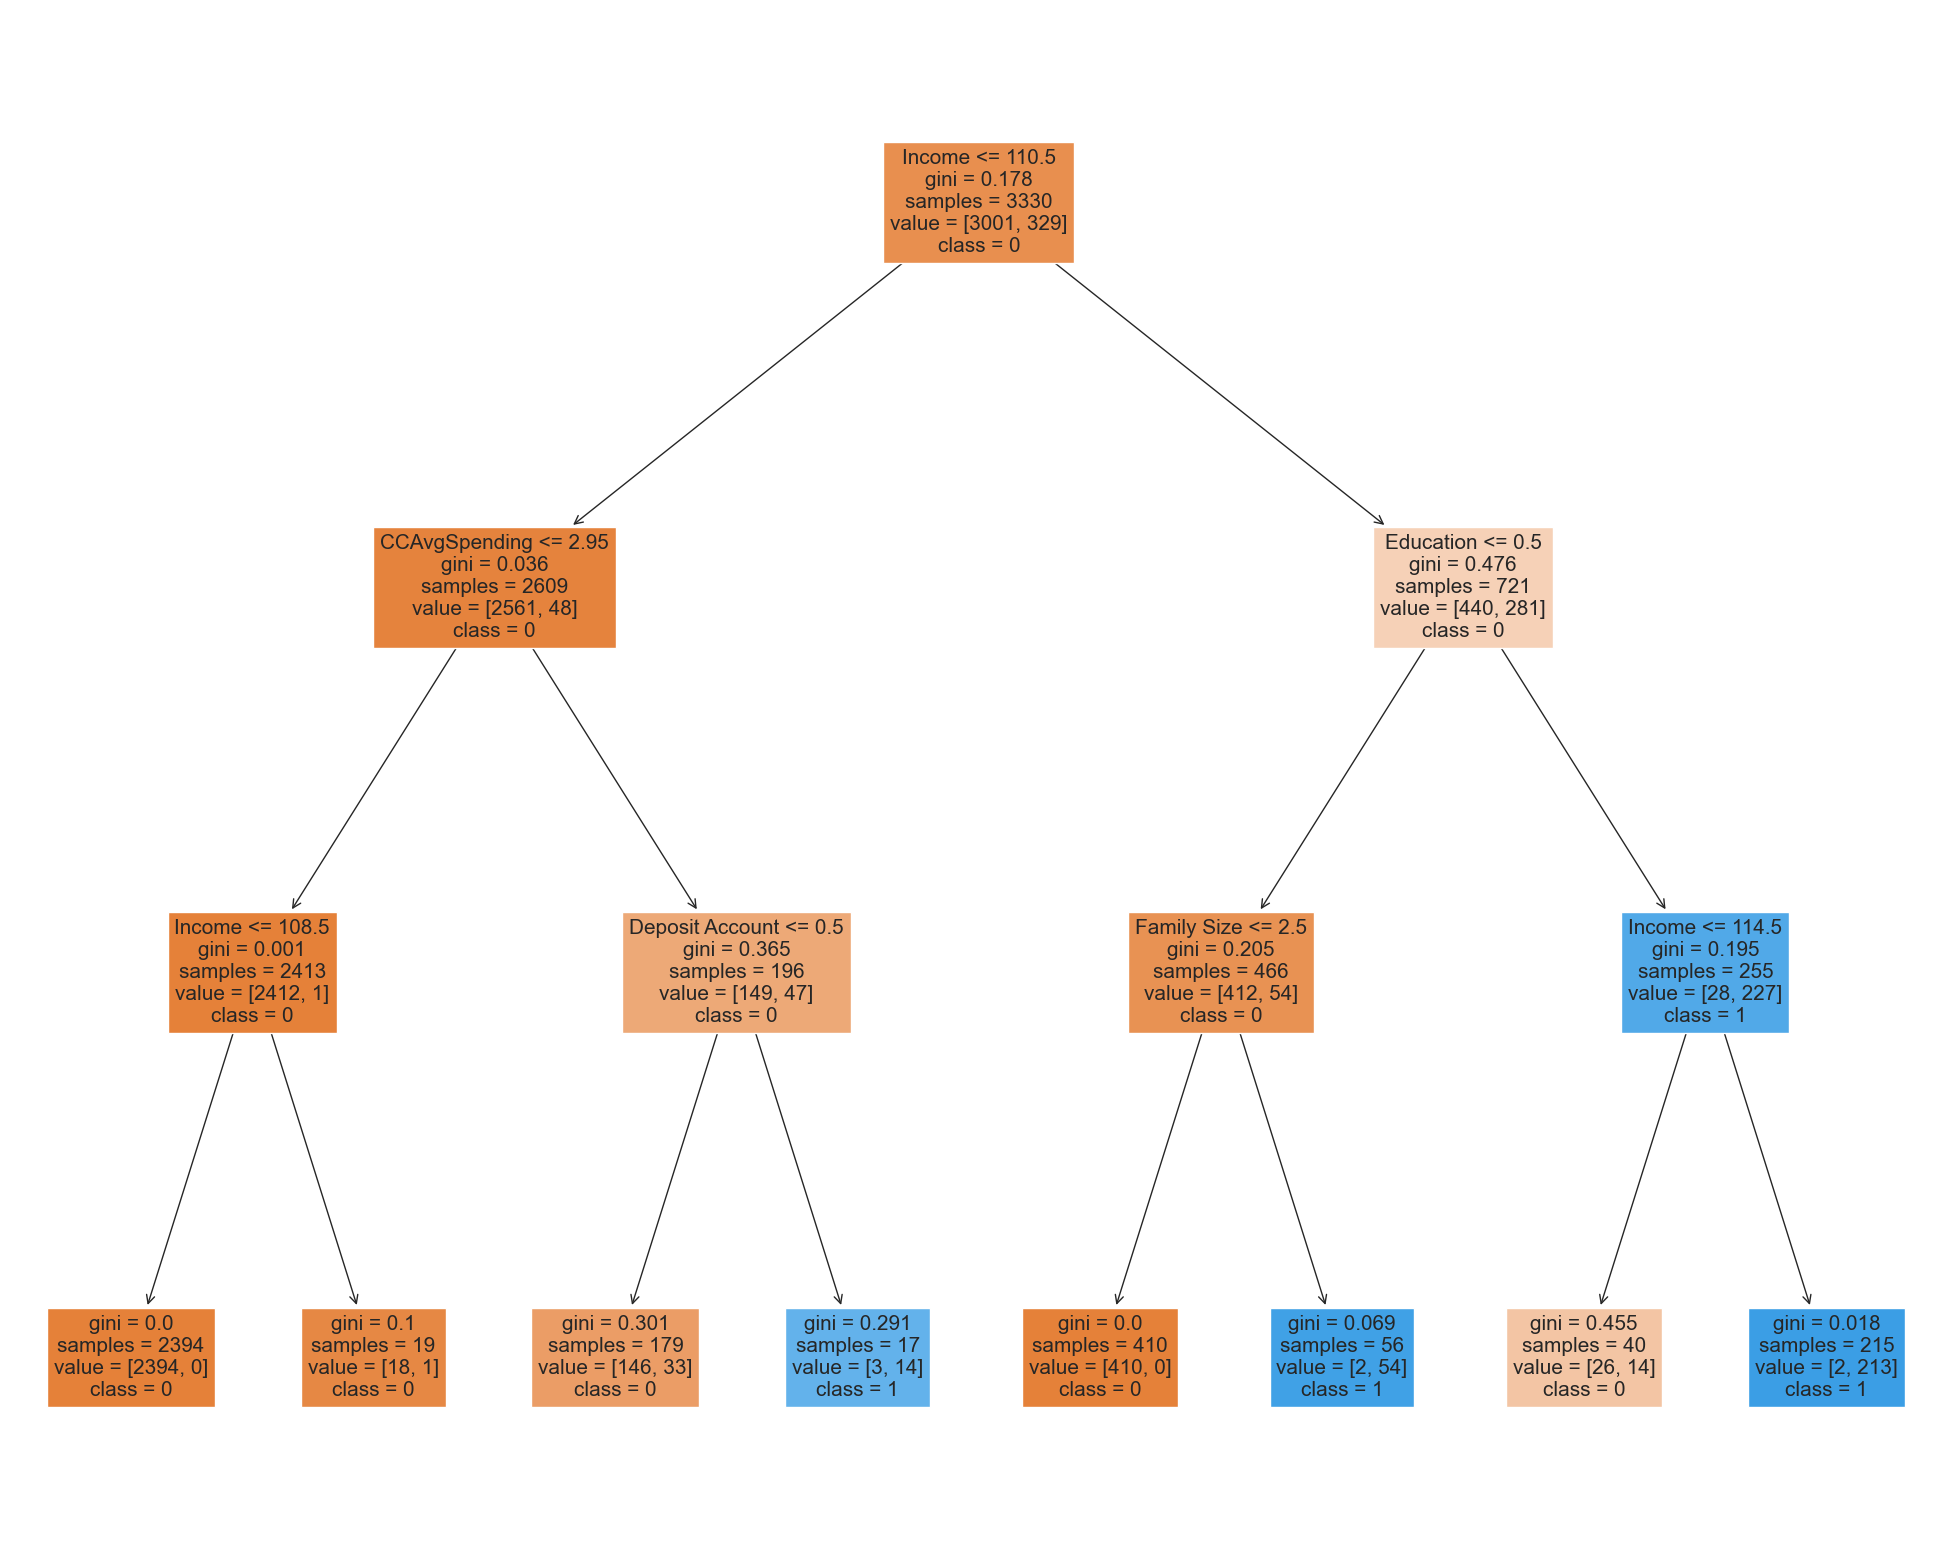

In [44]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(classifier, 
                   feature_names=X_train.columns,  
                   class_names=['0','1'],
                   filled=True)

In [45]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [46]:
fpr, tpr, thresholds = roc_curve(ar_compare_tree['actual'], ar_compare_tree['probabilities'])
roc_auc = auc(fpr, tpr)

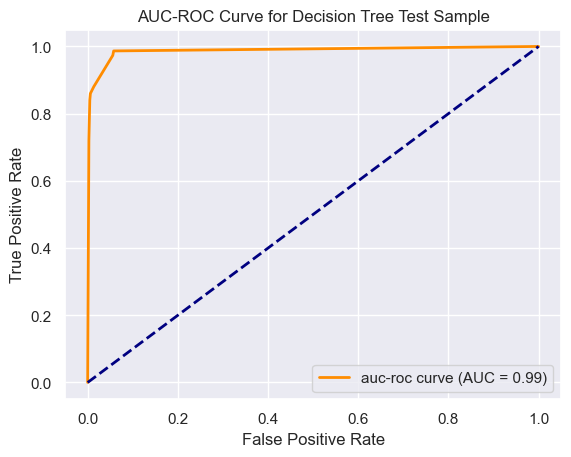

In [47]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='auc-roc curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve for Decision Tree Test Sample')
plt.legend(loc='lower right')
plt.show()

In [48]:
ROC = roc_auc_score(ar_compare_tree['actual'], ar_compare_tree['probabilities'])
print('AUC-ROC: ' + str(ROC))

AUC-ROC: 0.9872591102168568


In [49]:
gini_coefficient = 2 * roc_auc - 1
gini_coefficient

0.9745182204337135